In [17]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

for density 
* generate lenstronomy lens at a given pixel density
* start timer
* convert that to pandeia input
* run pandeia
* save figure
* stop time
* record time

In [54]:
import sys
import os
import json
import math
import time
import pickle
import copy

from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'
import numpy as np

from astropy.wcs import WCS
from astropy.table import Table
import astropy.wcs.utils

from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import get_telescope_config, get_instrument_config, build_default_calc, build_default_source
from pandeia.engine.io_utils import read_json, write_json

from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
gauss = GaussianEllipse()
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Data.psf import PSF
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman

In [19]:
data_set_name = 'J9OP04010'
oversample_factor = 1

Get brightness

In [ ]:
# TODO

Import modeled lenstronomy parameters

In [77]:
modeled_lenses_dir = os.path.join(repo_path, 'data', 'modeled_lenses')

lens_file = open(os.path.join(modeled_lenses_dir, data_set_name + '_lens'), 'rb')
kwargs_lens = pickle.load(lens_file)
lens_file.close()

lens_light_file = open(os.path.join(modeled_lenses_dir, data_set_name + '_lens_light'), 'rb')
kwargs_lens_light = pickle.load(lens_light_file)
lens_light_file.close()

source_file = open(os.path.join(modeled_lenses_dir, data_set_name + '_source'), 'rb')
kwargs_source_light = pickle.load(source_file)
source_file.close()

In [21]:
# mass model
lens_model_list = ['SIE', 'SHEAR']
lens_model_class = LensModel(lens_model_list)

# light model
lens_light_model_list = ['SERSIC_ELLIPSE']
lens_light_model_class = LightModel(lens_light_model_list)

# source model
source_model_list = ['SERSIC_ELLIPSE']
source_model_class = LightModel(source_model_list)

kwargs_model = {'lens_model_list': lens_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'source_light_model_list': source_model_list}

kwargs_psf = {'psf_type': 'NONE'}
psf_class = PSF(**kwargs_psf)

kwargs_numerics = {'supersampling_factor': 4,
                'supersampling_convolution': False}

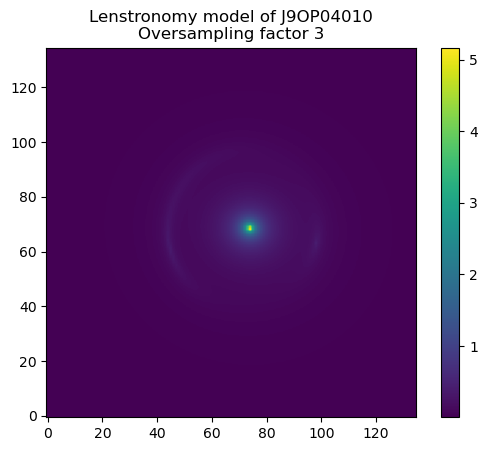

In [22]:
side = 5  # arcseconds
num_pix = 45 * oversample_factor
delta_pix = side / num_pix  # size of pixel in angular coordinates

ra_at_xy_0, dec_at_xy_0 = -delta_pix * math.ceil(num_pix / 2), -delta_pix * math.ceil(num_pix / 2) # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * delta_pix  # linear translation matrix of a shift in pixel in a shift in coordinates

kwargs_pixel = {'nx': num_pix, 'ny': num_pix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)

imageModel = ImageModel(data_class=pixel_grid,
                        psf_class=psf_class,
                        lens_model_class=lens_model_class,
                        source_model_class=source_model_class,
                        lens_light_model_class=lens_light_model_class,
                        kwargs_numerics=kwargs_numerics)

image = imageModel.image(kwargs_lens=kwargs_lens,
                        kwargs_source=kwargs_source_light,
                        kwargs_lens_light=kwargs_lens_light)

plt.imshow(image)
plt.title('Lenstronomy model of '+ data_set_name +'\nOversampling factor ' + str(oversample_factor))
# plt.savefig(os.path.join('figures', 'pixel_density_test', 'model_' + str(oversample_factor) + '.png'))
plt.colorbar()
plt.show()

model_array_path = os.path.join(repo_path, 'arrays', 'SLACS', data_set_name + '_model_' + str(oversample_factor) + '.npy')
np.save(model_array_path, image)

In [23]:
model = np.load(model_array_path)

In [84]:
calc = build_default_calc('roman','wfi','imaging')

# don't allow scene size to change
calc['configuration']['dynamic_scene'] = True
calc['configuration']['max_scene_size'] = 5

# change filter
calc['configuration']['instrument']['filter'] = 'f106'

# adjust brightness (np.interp for now)
max = np.max(model)
min = np.min(model)
model = np.interp(model, (min, max), (0.000001, 0.001))

In [85]:
i = 0

print('Converting to point sources...')
for row_number, row in tqdm(enumerate(model)):
    for item_number, item in enumerate(row):
        if i != 0:
            calc['scene'].append(build_default_source(geometry="point"))
        calc['scene'][i]['position']['x_offset'] = (item_number * (1 / 9) * (1 / oversample_factor)) + ra_at_xy_0 # arcsec
        calc['scene'][i]['position']['y_offset'] = (row_number * (1 / 9) * (1 / oversample_factor)) + dec_at_xy_0 # arcsec
        calc['scene'][i]['spectrum']['normalization']['norm_flux'] = item

        i += 1
print('Point source conversion complete')

Converting to point sources...


135it [01:41,  1.33it/s]

Point source conversion complete


In [86]:
print('Performing Pandeia calculation...')
results = perform_calculation(calc)
print('Pandeia calculation complete')

detector = results['2d']['detector']

Performing Pandeia calculation...


Pandeia calculation complete


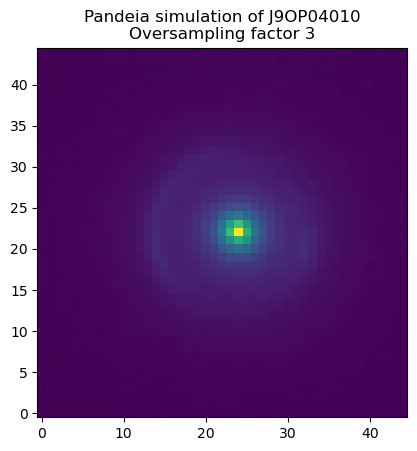

<Figure size 640x480 with 0 Axes>

In [87]:
# TODO TEMP! flip image
detector = np.flipud(detector)
# detector = np.fliplr(detector)

plt.imshow(detector)
plt.title('Pandeia simulation of ' + data_set_name + '\nOversampling factor ' + str(oversample_factor))
plt.show()
plt.savefig(os.path.join(repo_path, 'figures', 'SLACS', data_set_name + '_pandeia_' + str(oversample_factor) + '.png'))

In [88]:
# save this numpy array
pandeia_array_path = os.path.join(repo_path, 'arrays', 'SLACS', data_set_name + '_pandeia_' + str(oversample_factor) + '.npy')
np.save(pandeia_array_path, detector)

Use lenstronomy Roman module

In [89]:
# Roman_F062 = Roman(band='F062', psf_type='GAUSSIAN', survey_mode='wide_area')
# Roman_Z087 = Roman(band='F087', psf_type='GAUSSIAN', survey_mode='microlensing')
Roman_Y106 = Roman(band='F106', psf_type='GAUSSIAN', survey_mode='wide_area')
# Roman_J129 = Roman(band='F129', psf_type='GAUSSIAN', survey_mode='wide_area')
# Roman_H158 = Roman(band='F158', psf_type='GAUSSIAN', survey_mode='wide_area')
# Roman_F184 = Roman(band='F184', psf_type='GAUSSIAN', survey_mode='wide_area')
# Roman_W146 = Roman(band='F146', psf_type='GAUSSIAN', survey_mode='microlensing')

# kwargs_f062 = Roman_F062.kwargs_single_band()
kwargs_f106 = Roman_Y106.kwargs_single_band()
# kwargs_f129 = Roman_J129.kwargs_single_band()
# kwargs_f158 = Roman_H158.kwargs_single_band()
# kwargs_f184 = Roman_F184.kwargs_single_band()

In [90]:
roman_pixel_scale = Roman_Y106.kwargs_single_band().get('pixel_scale')
print('Roman\'s pixel scale: ' + str(roman_pixel_scale))

roman_num_pix = int(5 / roman_pixel_scale)

Roman's pixel scale: 0.11


In [91]:
# sim_f062 = SimAPI(numpix=roman_num_pix, kwargs_single_band=kwargs_f062, kwargs_model=kwargs_model)
sim_f106 = SimAPI(numpix=roman_num_pix, kwargs_single_band=kwargs_f106, kwargs_model=kwargs_model)
# sim_f129 = SimAPI(numpix=roman_num_pix, kwargs_single_band=kwargs_f129, kwargs_model=kwargs_model)
# sim_f158 = SimAPI(numpix=roman_num_pix, kwargs_single_band=kwargs_f158, kwargs_model=kwargs_model)
# sim_f184 = SimAPI(numpix=roman_num_pix, kwargs_single_band=kwargs_f184, kwargs_model=kwargs_model)

# imSim_kwargs_f062 = sim_f062.image_model_class(kwargs_numerics)
imSim_kwargs_f106 = sim_f106.image_model_class(kwargs_numerics)
# imSim_kwargs_f129 = sim_f129.image_model_class(kwargs_numerics)
# imSim_kwargs_f158 = sim_f158.image_model_class(kwargs_numerics)
# imSim_kwargs_f184 = sim_f184.image_model_class(kwargs_numerics)

In [92]:
print(kwargs_source_mag_f106)

[[{'R_sersic': 0.3425666588342633, 'n_sersic': 1.9060396137482356, 'e1': 0.08797360036823028, 'e2': -0.12251699432454795, 'center_x': 0.13370935038120507, 'center_y': 0.005860427596098174, 'magnitude': 26.5}]]


In [93]:
print(kwargs_source_light)

[{'amp': 11.196713947296052, 'R_sersic': 0.3425666588342633, 'n_sersic': 1.9060396137482356, 'e1': 0.08797360036823028, 'e2': -0.12251699432454795, 'center_x': 0.13370935038120507, 'center_y': 0.005860427596098174}]


In [94]:
# set lens light magnitudes
# lens_light_mag_f062 = 14.
lens_light_mag_f106 = 22.5
# lens_light_mag_f129 = 15.
# lens_light_mag_f158 = 16.
# lens_light_mag_f184 = 16.

# set source light magnitudes
# source_mag_f062 = 18.
source_mag_f106 = 26.5
# source_mag_f129 = 17.
# source_mag_f158 = 16.
# source_mag_f184 = 16.

# lens light (`kwargs_sersic_lens`)
# kwargs_lens_light_mag_f062 = [copy.deepcopy(kwargs_sersic_lens)]
# del kwargs_lens_light_mag_f062[0]['amp']
# kwargs_lens_light_mag_f062[0]['magnitude'] = lens_light_mag_f062

kwargs_lens_light_mag_f106 = [copy.deepcopy(kwargs_lens_light)]
del kwargs_lens_light_mag_f106[0][0]['amp']
kwargs_lens_light_mag_f106[0][0]['magnitude'] = lens_light_mag_f106

# kwargs_lens_light_mag_f129 = [copy.deepcopy(kwargs_sersic_lens)]
# del kwargs_lens_light_mag_f129[0]['amp']
# kwargs_lens_light_mag_f129[0]['magnitude'] = lens_light_mag_f129

# kwargs_lens_light_mag_f158 = [copy.deepcopy(kwargs_sersic_lens)]
# del kwargs_lens_light_mag_f158[0]['amp']
# kwargs_lens_light_mag_f158[0]['magnitude'] = lens_light_mag_f158

# kwargs_lens_light_mag_f184 = [copy.deepcopy(kwargs_sersic_lens)]
# del kwargs_lens_light_mag_f184[0]['amp']
# kwargs_lens_light_mag_f184[0]['magnitude'] = lens_light_mag_f184

# source light (`kwargs_sersic`)
# kwargs_source_mag_f062 = [copy.deepcopy(kwargs_sersic)]
# del kwargs_source_mag_f062[0]['amp']
# kwargs_source_mag_f062[0]['magnitude'] = source_mag_f062

kwargs_source_mag_f106 = [copy.deepcopy(kwargs_source_light)]
del kwargs_source_mag_f106[0][0]['amp']
kwargs_source_mag_f106[0][0]['magnitude'] = source_mag_f106

# kwargs_source_mag_f129 = [copy.deepcopy(kwargs_sersic)]
# del kwargs_source_mag_f129[0]['amp']
# kwargs_source_mag_f129[0]['magnitude'] = source_mag_f129

# kwargs_source_mag_f158 = [copy.deepcopy(kwargs_sersic)]
# del kwargs_source_mag_f158[0]['amp']
# kwargs_source_mag_f158[0]['magnitude'] = source_mag_f158

# kwargs_source_mag_f184 = [copy.deepcopy(kwargs_sersic)]
# del kwargs_source_mag_f184[0]['amp']
# kwargs_source_mag_f184[0]['magnitude'] = source_mag_f184

# kwargs_lens_light_f062, kwargs_source_f062, _ = sim_f062.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_f062, kwargs_source_mag=kwargs_source_mag_f062)
kwargs_lens_light_f106, kwargs_source_f106, _ = sim_f106.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_f106, kwargs_source_mag=kwargs_source_mag_f106)
# kwargs_lens_light_f129, kwargs_source_f129, _ = sim_f129.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_f129, kwargs_source_mag=kwargs_source_mag_f129)
# kwargs_lens_light_f158, kwargs_source_f158, _ = sim_f158.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_f158, kwargs_source_mag=kwargs_source_mag_f158)
# kwargs_lens_light_f184, kwargs_source_f184, _ = sim_f184.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_f184, kwargs_source_mag=kwargs_source_mag_f184)

TypeError: list indices must be integers or slices, not str

In [ ]:
# image_f062 = imSim_kwargs_f062.image(kwargs_lens=kwargs_lens, kwargs_lens_light=kwargs_lens_light_f062, kwargs_source=kwargs_source_f062)
image_f106 = imSim_kwargs_f106.image(kwargs_lens=kwargs_lens, kwargs_lens_light=kwargs_lens_light_f106, kwargs_source=kwargs_source_f106)
# image_f129 = imSim_kwargs_f129.image(kwargs_lens=kwargs_lens, kwargs_lens_light=kwargs_lens_light_f129, kwargs_source=kwargs_source_f129)
# image_f158 = imSim_kwargs_f158.image(kwargs_lens=kwargs_lens, kwargs_lens_light=kwargs_lens_light_f158, kwargs_source=kwargs_source_f158)
# image_f/184 = imSim_kwargs_f184.image(kwargs_lens=kwargs_lens, kwargs_lens_light=kwargs_lens_light_f184, kwargs_source=kwargs_source_f184)

# add noise
# image_f062 += sim_f062.noise_for_model(model=image_f062)
image_f106 += sim_f106.noise_for_model(model=image_f106)
# image_f129 += sim_f129.noise_for_model(model=image_f129)
# image_f158 += sim_f158.noise_for_model(model=image_f158)
# image_f184 += sim_f184.noise_for_model(model=image_f184)

# roman_image = np.zeros((image_f062.shape[0], image_f062.shape[1], 3), dtype=float)
# print(roman_image.shape)
# roman_image[:,:,0] = plot_util.sqrt(image_f062, scale_min=0, scale_max=10000)
# roman_image[:,:,0] = plot_util.sqrt(image_f106, scale_min=0, scale_max=10000)
# roman_image[:,:,1] = plot_util.sqrt(image_f129, scale_min=0, scale_max=10000)
# roman_image[:,:,2] = plot_util.sqrt(image_f158, scale_min=0, scale_max=10000)
# roman_image[:,:,2] = plot_util.sqrt(image_f184, scale_min=0, scale_max=10000)

In [ ]:
plt.imshow(image_f106, aspect='equal', origin='lower')
plt.title('Lenstronomy simulation of ' + data_set_name + '(F106)')
plt.savefig(os.path.join(repo_path, 'figures', 'SLACS', data_set_name + '_lenstronomy_roman_' + str(oversample_factor) + '.png'))
plt.show()

In [ ]:
# save this numpy array
lenstronomy_roman_array_path = os.path.join(repo_path, 'arrays', 'SLACS', data_set_name + '_lenstronomy_roman_' + str(oversample_factor) + '.npy')
np.save(lenstronomy_roman_array_path, image_f106)